# Отток клиентов

## Описание данных

Предоставляется два основных типа услуг: 
1. Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (*DSL*), оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:
- Антивирус (*DeviceProtection*);
- Блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*);
- Каталог фильмов (*StreamingMovies*).

Варианты договора:
- Ежемесячная оплата;
- Договор на 1 год;
- Договор на 2 года.

Доступны различные способы расчёта и возможность получения электронного чека.


**Файлы с данными:**

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.


Информация о договорах актуальна на 1 февраля 2020. Признак `customerID` - содержит код клиента.

## Импорт библиотек

In [1]:
!pip install -U  numpy pandas seaborn lightgbm catboost 1>/dev/null

In [2]:
import warnings
warnings.filterwarnings('ignore')

# загрузка/сохранение данных
import requests
from urllib.parse import urlencode

import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import scipy.stats as st
import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, make_scorer, precision_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Функции

In [3]:
RANDOM = 12345


def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url


def get_data_info(df):
  """
  Получение информации о датафрейме
  df - датафрейм
  """
  line = "\n" + "="*100 +"\n"
  print("Количество данных:", df.shape)
  print("Дубликаты:        ", df.duplicated().sum(), line)
  print(df.info(), line)
  print(df.describe())


def build_axes(count, cols=3, y_delta=1, x_delta=1):
  """
  Получение объектов координат группы графиков
  count   - количество графиков
  cols    - количество столбцов
  y_delta - - во сколько наз увеличить график по оси Y
  x_delta - - во сколько наз увеличить график по оси X
  """
  ost = 1 if count % cols else 0
  rows = count // cols + ost
  cnt = 0
  _, axes = plt.subplots(rows, cols, figsize=(cols*5*x_delta, rows*5*y_delta))
  if rows == 1: axes = np.array([axes])
  return axes


def features_info(df, features, cols=3, rot=0, kind='dist', y_delta=1, x_delta=1):
  """
  Построение группы гравиков
  df - датафрейм
  features - признаки
  cols     - количество столбцов
  rot      - поворот подписей оси X
  kind     - вид графика
  y_delta  - во сколько наз увеличить график по оси Y
  x_delta  - во сколько наз увеличить график по оси X
  """

  cnt = 0
  n = len(features)
  axes = build_axes(n, cols=cols, y_delta=y_delta, x_delta=x_delta)
  rows, cols = axes.shape

  for i in range(rows):
      for j in range(cols):
          if cnt == n: break
          feature = features[cnt]
          ax = axes[i][j]

          if kind == 'hist':
            sns.histplot(df[feature], ax=ax)
            title = feature + " histogram"
          elif kind == 'dist':
            sns.distplot(df[feature], ax=ax)
            title = feature + " distribution"
          else:
            sns.boxplot(df[feature], ax=ax);
            title = feature + " boxplot"

          ax.set_title(title)
          ax.tick_params(axis='x', labelrotation=rot)
          cnt += 1
  plt.tight_layout()


def check_df_nan(data):
    """
    Получение количества пропусков в процентном соотношении (и типы данных 
    для каждого столбца с пропусками)
    data - таблица с данными
    """
    
    df_length = data.shape[0]
    null_stat = {}

    for col in data.columns:
        col_nan = data[data[col].isnull()].shape[0]
        pct = col_nan / df_length * 100

        if pct > 0:
            null_stat[col] = [round(pct, 1), data[col].dtype]
    
    info = (pd.DataFrame
     .from_dict(null_stat, orient='index', columns=['percentage', 'data_type'])
     .sort_values(by='percentage', ascending=False)
    )
    
    return info


def churn_stat(df, group):
  """
  Получение статистики в группировке по целевому признаку Churn
  """

  N = len(df)
  group_df = df.groupby([group])['Churn'].agg(['count','sum'])
  group_df.columns = ['Total', 'Churn']
  group_df['Part'] =round((group_df.Churn / group_df.Total), 2)
  group_df['Total part'] =round((group_df.Churn / N), 2)
  return group_df


def get_importance(X, y):
  """
  Получение важности признаков
  X - признаки
  y - целевой признак
  """

  importance = []
  for _ in range(10):
    model = RandomForestClassifier(
        n_estimators=100, max_depth=30,
    )
    model.fit(X, y)
    importance.append(model.feature_importances_)

  df = pd.DataFrame(importance).transpose()
  df.index = X.columns
  df['avg'] = df[df.columns].apply('mean', axis=1)
  return df[['avg']].sort_values(by='avg', ascending=False)


def score_stat(clf, X, y, X_t, y_t):
  """
  Вывод статистики значений метрик заданной модели
  clf - обученная модель
  X   - признаки обучающей выборки
  y   - целевой признак обучающей выборки
  X_t - признаки тестовой выборки
  y_t - целевой признак тестовой выборки
  """
  pred_train = clf.predict(X)
  pred_test  = clf.predict(X_t)
  score_dict = {'Accuracy': [accuracy_score(y, pred_train), accuracy_score(y_t, pred_test)],
                'ROC-AUC': [roc_auc_score(y, pred_train), roc_auc_score(y_t, pred_test)],
                'Precision': [precision_score(y, pred_train), precision_score(y_t, pred_test)],
                'Recall': [recall_score(y, pred_train), recall_score(y_t, pred_test)],
                'F1': [f1_score(y, pred_train), f1_score(y_t, pred_test)]
                }
  return pd.DataFrame(score_dict, index=['train', 'test']).transpose()


def random_search(estimator, params, X, y, iter=100, scoring='roc_auc', cv=5, v=1):
  """
  Поиск параментров по сетке с помощью RandomizedSearchCV()
  estimator - заданный алгоритм
  params    - сетка параметров
  iter      - количество итераций
  X         - признаки
  y         - целевой признак
  scoring   - метрика для оценки
  cv        - количество фолдов
  v         - значение verbose
  """
  clf = RandomizedSearchCV(estimator, params, n_iter=iter, scoring=scoring, 
                    n_jobs=-1, cv=cv, verbose=v, random_state=RANDOM)
  clf.fit(X, y)
  print('The best params:', clf.best_params_)
  return clf.best_estimator_


def grid_search(estimator, params, X, y, scoring='roc_auc', cv=5, v=1):
  """
  Поиск параментров по сетке с помощью GridSearchCV()
  estimator - заданный алгоритм
  params    - сетка параметров
  X         - признаки
  y         - целевой признак
  scoring   - метрика для оценки
  cv        - количество фолдов
  v         - значение verbose
  """
  clf = GridSearchCV(estimator, params, scoring=scoring, 
                    n_jobs=-1, cv=cv, verbose=v).fit(X, y)
  print('\nThe best score: ', clf.best_score_)
  print('\nThe best params:', clf.best_params_) 
  # return clf.best_estimator_
  return clf


def get_balanced(df, y, n=2, c=1):
  """
  Балансировка заданного класса
  df - датафрейм 
  y  - имя целевого признака
  n  - во сколько раз увеличить требуемый класс
  c  - класс, который нужно увеличить
  """
  print('\nBefore:')
  print(df[y].value_counts())

  ones  = df[df[y] == c]
  other = df[df[y] != c]
  df_list = [other]
  df_list.extend([ones]*n)
  balanced_df = shuffle(pd.concat(df_list), random_state=RANDOM)

  print('\nAfter:')
  print(balanced_df[y].value_counts())
  return balanced_df


def split_data(df, y):
  """
  Разделение признаков и целевой переменной
  df - датафрейм 
  y  - имя целевого признака
  """
  return df.drop(y, axis=1), df[y]

In [4]:
DATA_CONTRACT = "https://yadi.sk/d/J0ACBWNzDaeGew"
DATA_INTERNET = "https://yadi.sk/d/_seiIhzeBbcoDQ"
DATA_PERSONAL = "https://yadi.sk/d/wbi8YswJZm64WA"
DATA_PHONE    = "https://yadi.sk/d/DxUji4OeUyAtwg"

## Исследовательский анализ данных

### contract

In [5]:
contract = pd.read_csv(get_url(DATA_CONTRACT))
contract.head()

Run https://yadi.sk/d/J0ACBWNzDaeGew


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
contract.EndDate.unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [7]:
get_data_info(contract)

Количество данных: (7043, 8)
Дубликаты:         0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None 

       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


In [8]:
# проверяем TotalCharges на неявные пропуски
nan_index = contract[contract.TotalCharges.str.contains('[a-zA-Z\s]', regex=True)].index
contract.loc[nan_index, :]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Обнаружены неявные пропуски в признаке *TotalCharges*. Заменим их на 0, исправим тип данных на float.

In [9]:
# Посмотрим на продолжительность работы с клиентами, у которых пропуски в TotalCharges
index = contract[contract.TotalCharges == 0].index
contract.loc[index, ['BeginDate', 'EndDate']]

,BeginDate,EndDate


Данные предоставлены на момент 01.02.2020. Соответственно 11 клиентов с пропусками - новые клиенты.



In [10]:
contract.loc[nan_index, 'TotalCharges'] = 0
contract['TotalCharges'] = contract.TotalCharges.astype('float')
print('Пропуски в TotalCharges:', contract.TotalCharges.isna().sum())

Пропуски в TotalCharges: 0


In [11]:
# Исправим типы данных для других признаков.
contract['BeginDate'] = contract.BeginDate.astype('datetime64')

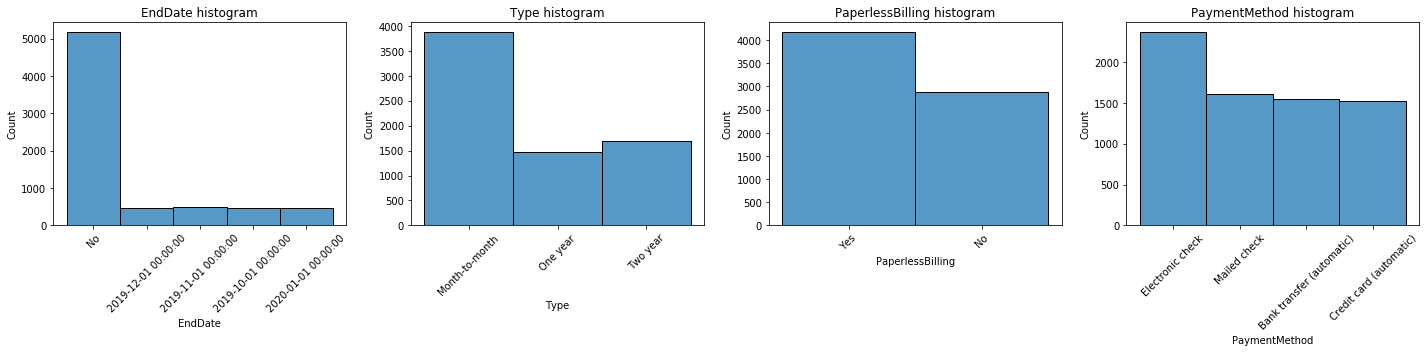

In [12]:
# Информация о значениях других категориальных признаках
features_info(contract, ['EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod'], rot=45, kind='hist', cols=4)

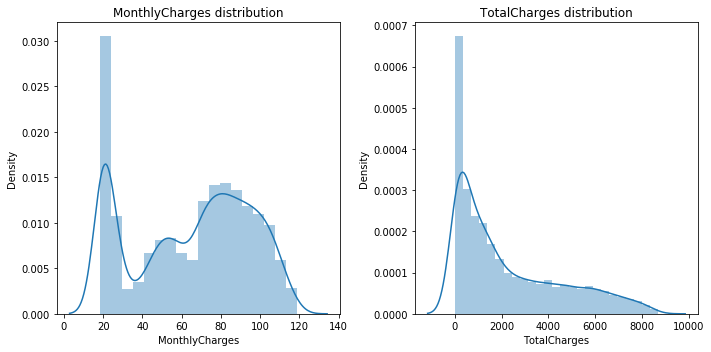

In [13]:
# распределение числовых признаков
features_info(contract, ['MonthlyCharges', 'TotalCharges'], cols=2, kind='dist')

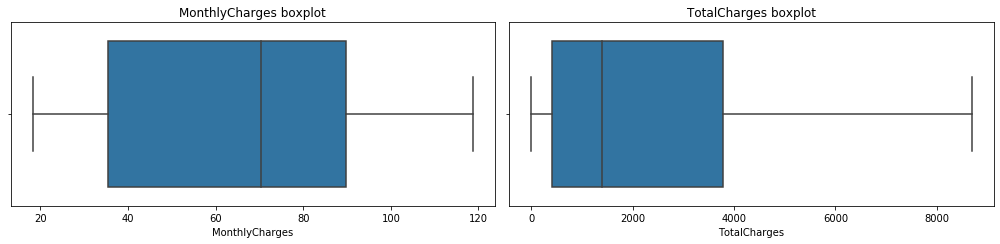

In [14]:
features_info(contract, ['MonthlyCharges', 'TotalCharges'], cols=2, kind='box', y_delta=0.7, x_delta=1.4)

**Вывод**

* В данных о ежемесячных платежах есть пропуски (заполнены)
* Дубликаты отсутствуют
* Исправлены типы данных для признаков
* Признаки *MonthlyCharges, TotalCharges* - числовые; BeginDate - дата; остальные - категориальные
* *EndDate* - в неверном формате, будущая целевая переменная

Распределение признаков *MonthlyCharges,TotalCharges* не нормальное - не симметрично и не унимодально. Наблюдается большой пик около минимальных значений. Из диаграммы рассеяния следует, что в этих данных нет выбросов.

### internet

In [15]:
internet = pd.read_csv(get_url(DATA_INTERNET))
internet.head()

Run https://yadi.sk/d/_seiIhzeBbcoDQ


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [16]:
get_data_info(internet)

Количество данных: (5517, 8)
Дубликаты:         0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None 

        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     5168-MSWXT     Fiber optic             No           No   
freq             1            3096           3498         3088   

  

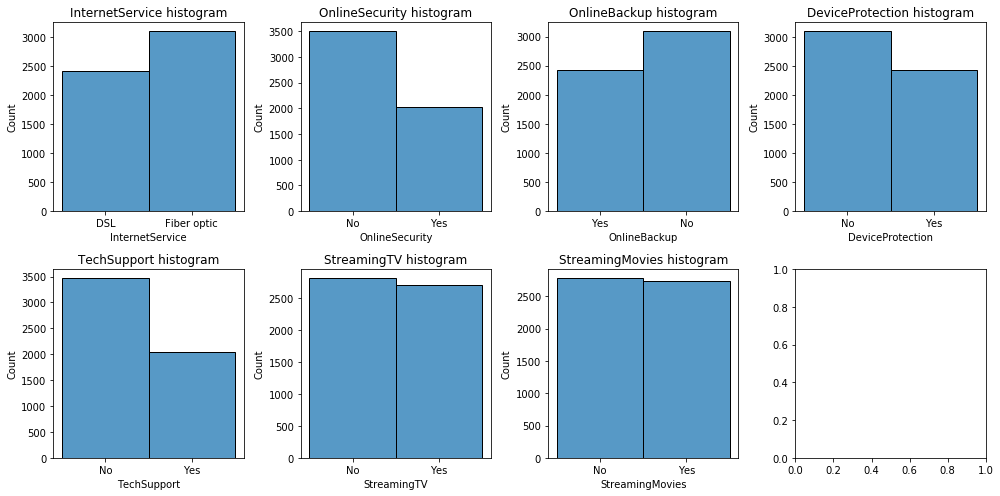

In [17]:
# гистограммы категориальных признаков
features_info(internet, internet.columns[1:], kind='hist', cols=4, y_delta=0.7, x_delta=0.7)

**Вывод**
* Все признаки категориальные
* В данных о предоставлении интернет-услуг нет пропусков
* В большинстве категориальных признаков присутствует значительный дисбаланс классов

### personal

In [18]:
personal = pd.read_csv(get_url(DATA_PERSONAL))
personal.head()

Run https://yadi.sk/d/wbi8YswJZm64WA


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [19]:
get_data_info(personal)

Количество данных: (7043, 5)
Дубликаты:         0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None 

       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [20]:
personal.SeniorCitizen.unique()

array([0, 1])

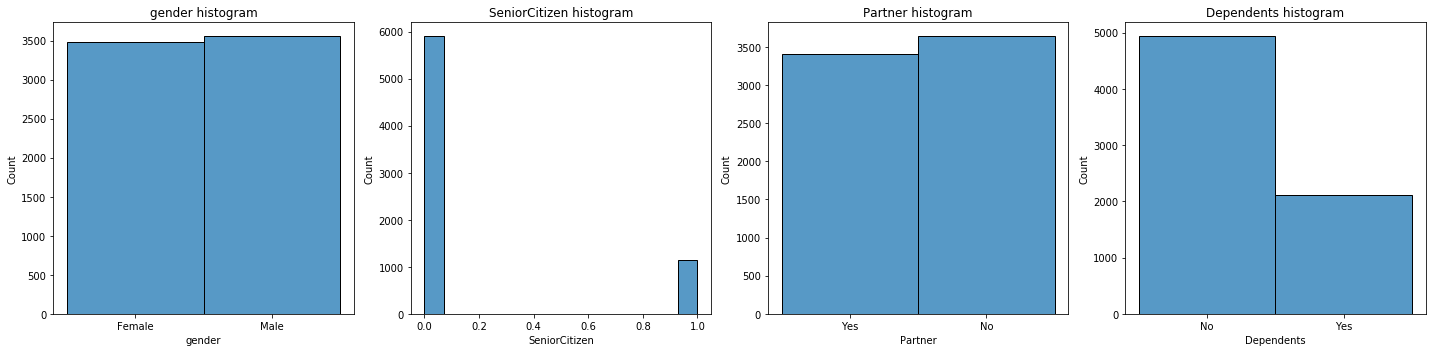

In [21]:
features_info(personal, personal.columns[1:], kind='hist', cols=4)

**Вывод**
* Все признаки категориальные
* В данных о клиентах нет пропусков и дубликатов
* В признаках присутствует значительный дисбаланс классов (*Dependents, SeniorCitizen*)

### phone

In [22]:
phone = pd.read_csv(get_url(DATA_PHONE))
phone.head()

Run https://yadi.sk/d/DxUji4OeUyAtwg


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [23]:
get_data_info(phone)

Количество данных: (6361, 2)
Дубликаты:         0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None 

        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5168-MSWXT            No
freq             1          3390


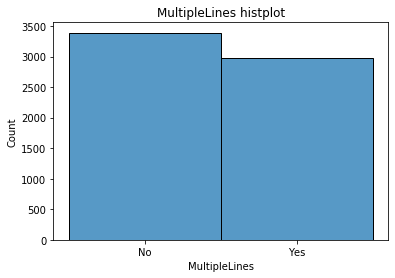

In [24]:
sns.histplot(phone.MultipleLines);
plt.title('MultipleLines histplot');

**Вывод**
* Все признаки категориальные
* В данных о звонках нет пропусков и дубликатов

### Объединение данных

In [25]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [26]:
# объединим данные из разных таблиц
telecom = contract.copy()
for df in [personal, phone, internet]:
  telecom = telecom.merge(df, how='outer', on='customerID')

telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     6361 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

In [27]:
# количество попусков после объединения данных
check_df_nan(telecom)

,percentage,data_type
InternetService,21.7,object
OnlineSecurity,21.7,object
OnlineBackup,21.7,object
DeviceProtection,21.7,object
TechSupport,21.7,object
StreamingTV,21.7,object
StreamingMovies,21.7,object
MultipleLines,9.7,object


Пропуски в категориальных признаках, скорее всего, говорят о том, что клиенты не пользуются интернет-услугами. Заполним значением 'No'.

In [28]:
telecom.fillna('No', inplace=True)
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

In [29]:
# добавим столбец с целевой переменной
telecom['Churn'] = telecom.EndDate.apply(lambda x: 0 if x=='No' else 1)

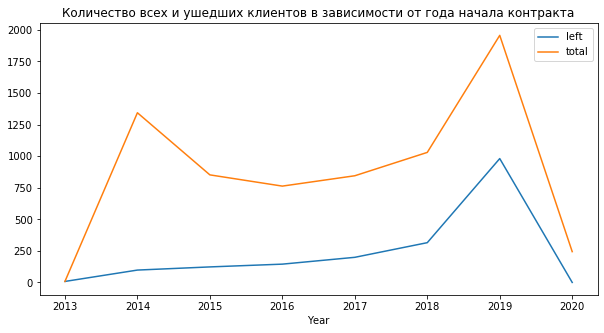

In [30]:
telecom2 = telecom.copy()
telecom2['Year'] = telecom2.BeginDate.dt.year
year_churn = telecom2.groupby('Year')['Churn'].agg(['sum', 'count'])
year_churn.columns = ['left', 'total']

_, ax = plt.subplots(figsize=(10,5))
year_churn.plot(ax=ax);
plt.title('Количество всех и ушедших клиентов в зависимости от года начала контракта');

Из графика видно, что резкое увеличение количества ушедших клиентов произошло в 2018-2019 году. Возможно, появился сильный конкурент с более выгодными условиями предоставления услуг.

In [31]:
telecom.groupby('Churn')['TotalCharges'].agg(['sum', 'mean', 'median'])

,sum,mean,median
Churn,,,
0,13193241.8,2549.911442,1679.525
1,2862926.9,1531.796094,703.550


Из сводных таблиц видно, что ушедшие клиенты в среднем платят за услуги в 2 раза меньше, чем действующие клиенты. Возможно, клиенты знают не обо всех услугах и тарифах.

In [32]:
# статистика по частоте оплаты
churn_stat(telecom, 'Type')

,Total,Churn,Part,Total part
Type,,,,
Month-to-month,3875,1655,0.43,0.23
One year,1473,166,0.11,0.02
Two year,1695,48,0.03,0.01


Клиенты, у которых контракт на месяц, составляют бОльшую долю среди оттока.

In [33]:
# статистика типу счета (бумажный или нет)
churn_stat(telecom, 'PaperlessBilling')

,Total,Churn,Part,Total part
PaperlessBilling,,,,
No,2872,469,0.16,0.07
Yes,4171,1400,0.34,0.20


БОльшую долю среди оттока составляют клинты, получающие бумажные счета.

In [34]:
# статистика по типу оплаты
churn_stat(telecom, 'PaymentMethod')

,Total,Churn,Part,Total part
PaymentMethod,,,,
Bank transfer (automatic),1544,258,0.17,0.04
Credit card (automatic),1522,232,0.15,0.03
Electronic check,2365,1071,0.45,0.15
Mailed check,1612,308,0.19,0.04


Большая часть оттока - клиенты, которые платят по электронному чеку.

In [35]:
# статистика по типу интернет-услуг
churn_stat(telecom, 'InternetService')

,Total,Churn,Part,Total part
InternetService,,,,
DSL,2421,459,0.19,0.07
Fiber optic,3096,1297,0.42,0.18
No,1526,113,0.07,0.02


18% клиентов - часть оттока, которая пользуется оптоволоконным интернетом.

### Вывод

Исходя из проведенного анализа данных можно сделать выводы:
* резкое увеличение количества ушедших клиентов в 2018-2019 году
* ушедшие клиенты в среднем платят за услуги в 2 раза больше, чем действующие
* 23% оттока, у которых контракт на месяц
* 20% оттока составляют клинты, получающие бумажные счета
* 15% оттока - клиенты, которые платят по электронному чеку.
* 18% клиентов - часть оттока, которая пользуется оптоволоконным интернетом.

## План
1. Кодирование признаков *Type, PaymentMethod, InternetService*
2. Исследование на важность признаков
3. Исследование на необходимость балансировки классов
4. Построение модели для задачи бинарной классификации (возможные варианты - CatBoost, LighGBM, XGBoost). Признак *Churn* - целевая переменная.
5. Метрики для оценки модели - F1, AUC-ROC

## Предобработка данных

### Преобразование данных

In [36]:
# Проведем преобразование данных - заменим столбцы с Yes/No на 1/0
columns = ['PaperlessBilling','Partner','Dependents', 'MultipleLines', 
           'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies'
           ]

for column in columns:
  telecom[column] = telecom[column].apply(lambda x: 1 if x=='Yes' else 0)

In [37]:
# заменим данные в EndDate: No -> 2020-02-01
telecom['EndDate'] = (telecom['EndDate'].str.replace('No', '2020-02-01').astype('datetime64'))

# добавим признак - длительность контракта
telecom['LifeTimeDay'] = (telecom['EndDate'].dt.to_period('D').astype(int) - 
                          telecom['BeginDate'].dt.to_period('D').astype(int))

### Кодирование

In [38]:
# кодирование категориальных признаков
object_features = ['PaymentMethod', 'Type', 'InternetService', 'gender']
telecom = telecom.join(pd.get_dummies(telecom[object_features], drop_first=True))
telecom.drop(object_features, axis=1, inplace=True)
telecom.drop(['customerID',	'BeginDate', 'EndDate'], axis=1, inplace=True)
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       7043 non-null   int64  
 1   MonthlyCharges                         7043 non-null   float64
 2   TotalCharges                           7043 non-null   float64
 3   SeniorCitizen                          7043 non-null   int64  
 4   Partner                                7043 non-null   int64  
 5   Dependents                             7043 non-null   int64  
 6   MultipleLines                          7043 non-null   int64  
 7   OnlineSecurity                         7043 non-null   int64  
 8   OnlineBackup                           7043 non-null   int64  
 9   DeviceProtection                       7043 non-null   int64  
 10  TechSupport                            7043 non-null   int64  
 11  Stre

In [39]:
telecom.columns

Index(['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
       'Partner', 'Dependents', 'MultipleLines', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Churn', 'LifeTimeDay',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Type_One year', 'Type_Two year', 'InternetService_Fiber optic',
       'InternetService_No', 'gender_Male'],
      dtype='object')

In [40]:
telecom.head(3)

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Churn,LifeTimeDay,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,gender_Male
0,1,29.85,29.85,0,1,0,0,0,1,0,...,0,31,0,1,0,0,0,0,0,0
1,0,56.95,1889.50,0,0,0,0,1,0,1,...,0,1036,0,0,1,1,0,0,0,1
2,1,53.85,108.15,0,0,0,0,1,1,0,...,1,61,0,0,1,0,0,0,0,1


### Важность признаков

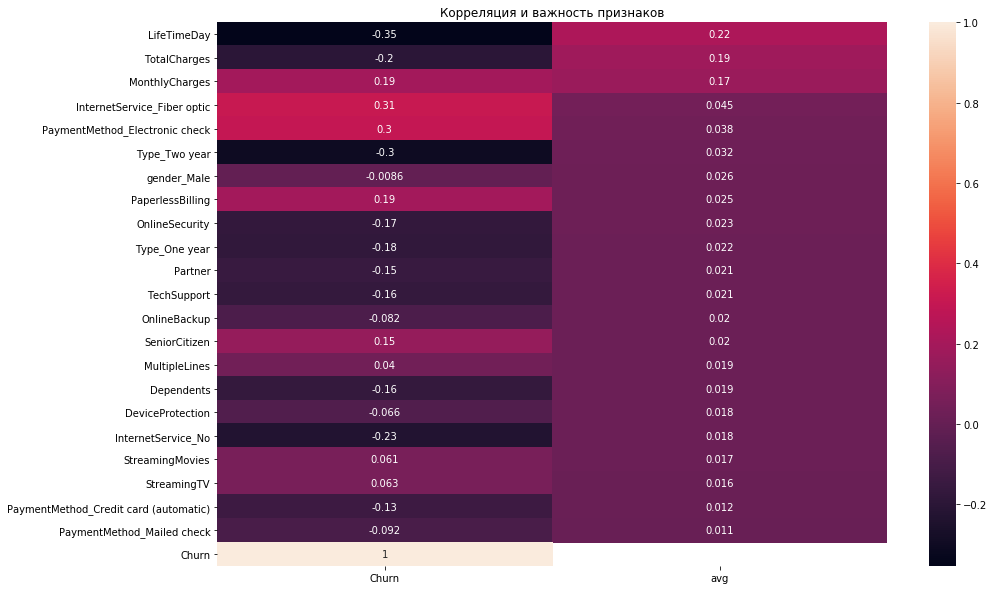

In [41]:
# коллинеарность с целевым признаком
corr = telecom.corr()
corr_churn = corr[['Churn']]

# получение важности признаков
importance = get_importance(telecom.drop(['Churn'], axis=1), telecom['Churn'])

# тепловая карта
_, ax = plt.subplots(1, figsize=(15,10))
corr_importance = corr_churn.join(importance)
sns.heatmap(corr_importance.sort_values('avg', ascending=False), annot=True, ax=ax);
plt.title('Корреляция и важность признаков');

In [42]:
# удаляем "неважные" признаки (согласно тепловой карте + эксперименты)
not_important = ['gender_Male', 'StreamingTV', 'StreamingMovies', 
                 'DeviceProtection', 'MultipleLines', 'OnlineSecurity',
                 'TotalCharges', 'MonthlyCharges', 'OnlineBackup', 'TechSupport',
                 'PaymentMethod_Mailed check', 'Dependents'
                 ]

telecom.drop(not_important, axis=1, inplace=True)

### Разделение на выборки

In [43]:
# разбиение на выборки
train, test = train_test_split(telecom, test_size=0.2, random_state=42)

# балансировка обучающей выборки
train = get_balanced(train, 'Churn',  n=3)

# отделяем целевой признак
X_train, y_train = split_data(train, 'Churn')
X_test, y_test = split_data(test, 'Churn')


Before:
0    4138
1    1496
Name: Churn, dtype: int64

After:
1    4488
0    4138
Name: Churn, dtype: int64


## Обучение моделей

### LogisticRegression

In [44]:
TRAIN_RESULTS = {}

In [45]:
%%time

params = {
  'C': range(10, 200, 10),
  'class_weight': [None, 'balanced'],
  'l1_ratio': range(1,15),
  'max_iter': [1000],
  'n_jobs': [-1],
  'penalty': ['l2'],
  'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
 }

# lg = grid_search(LogisticRegression(), params, X_train, y_train)
lg = random_search(LogisticRegression(), params, X_train, y_train, iter=10)

pprint(lg.get_params())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.6s finished


The best params: {'tol': 1e-05, 'penalty': 'l2', 'n_jobs': -1, 'max_iter': 1000, 'l1_ratio': 14, 'class_weight': 'balanced', 'C': 100}
{'C': 100,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 14,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 1e-05,
 'verbose': 0,
 'warm_start': False}
CPU times: user 417 ms, sys: 78.2 ms, total: 496 ms
Wall time: 7.07 s


In [46]:
score_stat(lg, X_train, y_train, X_test, y_test)

,train,test
Accuracy,0.755391,0.752307
ROC-AUC,0.753725,0.785239
Precision,0.750000,0.519544
Recall,0.794786,0.855228
F1,0.771744,0.646403


In [47]:
%%time

# обучение с лучшими найденными параметрами
lg_best = LogisticRegression(
    C=1.0, class_weight=None, dual=False, fit_intercept=True, 
    intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='auto', 
    n_jobs=None, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, 
    verbose=0, warm_start=False).fit(X_train, y_train)

lg_results = score_stat(lg_best, X_train, y_train, X_test, y_test)
TRAIN_RESULTS['LogisticRegression'] = lg_results.loc['ROC-AUC']

CPU times: user 832 ms, sys: 610 ms, total: 1.44 s
Wall time: 397 ms


In [48]:
lg_results

,train,test
Accuracy,0.755159,0.748048
ROC-AUC,0.753002,0.784059
Precision,0.744444,0.514423
Recall,0.806150,0.860590
F1,0.774069,0.643932


### LightGBM

In [49]:
%%time

lgbm_params = {
  'boosting_type': ['gbdt'],
  'max_depth': [18],
  'n_jobs': [-1],
  'num_leaves': range(42, 44), 
  'min_child_samples': [10,15], 
  'min_child_weight': [1e-2, 1e-1],
  'learning_rate': [0.0015],
  'class_weight': [None, 'balanced'],
  'subsample': [0.2, 0.4, 0.6, 0.8],
  'colsample_bytree': np.linspace(0,1,8),
  'reg_alpha': [0, 0.1],
  'reg_lambda': [0, 1, 5],
  'num_iterations': [100],
 }
 
# lgbm = grid_search(LGBMClassifier(), lgbm_params, X_train, y_train)
lgbm = random_search(LGBMClassifier(), lgbm_params, X_train, y_train, iter=10)

pprint(lgbm.get_params())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


The best params: {'subsample': 0.4, 'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 43, 'num_iterations': 100, 'n_jobs': -1, 'min_child_weight': 0.01, 'min_child_samples': 10, 'max_depth': 18, 'learning_rate': 0.0015, 'colsample_bytree': 0.42857142857142855, 'class_weight': 'balanced', 'boosting_type': 'gbdt'}
{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.42857142857142855,
 'importance_type': 'split',
 'learning_rate': 0.0015,
 'max_depth': 18,
 'min_child_samples': 10,
 'min_child_weight': 0.01,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_iterations': 100,
 'num_leaves': 43,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'silent': True,
 'subsample': 0.4,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}
CPU times: user 1.09 s, sys: 36.7 ms, total: 1.13 s
Wall time: 5.11 s


In [50]:
score_stat(lgbm, X_train, y_train, X_test, y_test)

,train,test
Accuracy,0.809993,0.805536
ROC-AUC,0.809138,0.821436
Precision,0.809472,0.591837
Recall,0.830214,0.855228
F1,0.819712,0.699561


In [51]:
%%time

# обучение с лучшими найденными параметрами
lgbm_best = LGBMClassifier(
    num_leaves=43, n_jobs=-1, min_child_weight=0.1, min_child_samples=10, 
    max_depth=18, boosting_type='gbdt').fit(X_train, y_train)

lgbm_results = score_stat(lgbm_best, X_train, y_train, X_test, y_test)
TRAIN_RESULTS['LGBMClassifier'] = lgbm_results.loc['ROC-AUC']

CPU times: user 1.04 s, sys: 11.4 ms, total: 1.05 s
Wall time: 326 ms


In [52]:
lgbm_results

,train,test
Accuracy,0.907141,0.865862
ROC-AUC,0.906126,0.867607
Precision,0.894669,0.697425
Recall,0.931150,0.871314
F1,0.912545,0.774732


### CatBoost

In [53]:
%%time

cb_params = {
  # 'iterations': [1000],
  'l2_leaf_reg': range(1,5),
  'min_data_in_leaf': [1,2,3],
  'depth': [3,6,10],
  'class_weights': [{1: 0.58, 0: 1.1}],
  'learning_rate': [0.05, 0.001],
 }

m = CatBoostClassifier(verbose=False)
# cb = grid_search(m, cb_params, X_train, y_train)
cb = random_search(m, cb_params, X_train, y_train, iter=10)
pprint(cb.get_params())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


The best params: {'min_data_in_leaf': 2, 'learning_rate': 0.001, 'l2_leaf_reg': 1, 'depth': 3, 'class_weights': {1: 0.58, 0: 1.1}}
{'class_weights': {0: 1.1, 1: 0.58},
 'depth': 3,
 'l2_leaf_reg': 1,
 'learning_rate': 0.001,
 'min_data_in_leaf': 2,
 'verbose': False}
CPU times: user 6.94 s, sys: 564 ms, total: 7.51 s
Wall time: 5min 32s


In [54]:
score_stat(cb, X_train, y_train, X_test, y_test)

,train,test
Accuracy,0.734524,0.822569
ROC-AUC,0.740201,0.767822
Precision,0.844514,0.669421
Recall,0.600267,0.651475
F1,0.701745,0.660326


In [55]:
%%time

# обучение с лучшими найденными параметрами
cb_best = CatBoostClassifier(
    class_weights={1: 0.58, 0: 1.1}, depth=6, iterations=1000, l2_leaf_reg=2, 
    min_data_in_leaf=1, verbose=False).fit(X_train, y_train)

cb_results = score_stat(cb_best, X_train, y_train, X_test, y_test)
TRAIN_RESULTS['CatBoostClassifier'] = cb_results.loc['ROC-AUC']

CPU times: user 10.3 s, sys: 1.18 s, total: 11.5 s
Wall time: 8.05 s


In [56]:
cb_results

,train,test
Accuracy,0.879550,0.911285
ROC-AUC,0.881863,0.887343
Precision,0.936030,0.829787
Recall,0.824866,0.836461
F1,0.876939,0.833111


### XGBClassifier

In [57]:
%%time

xgb_params = {
    "booster":['gbtree'],
    'colsample_bytree': np.linspace(0,1,8, endpoint=False),
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': range(3,20),
    'alpha': range(1, 20)
 }

# xgb = grid_search(XGBClassifier(), xgb_params, X_train, y_train)
xgb = random_search(XGBClassifier(), xgb_params, X_train, y_train, iter=10)
pprint(xgb.get_params())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.6s finished


The best params: {'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.375, 'booster': 'gbtree', 'alpha': 9}
{'alpha': 9,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.375,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 15,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 9,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}
CPU times: user 1.54 s, sys: 110 ms, total: 1.65 s
Wall time: 20.2 s


In [58]:
score_stat(xgb, X_train, y_train, X_test, y_test)

,train,test
Accuracy,0.827035,0.825408
ROC-AUC,0.825600,0.846960
Precision,0.816568,0.617811
Recall,0.860963,0.892761
F1,0.838178,0.730263


In [59]:
%%time

# обучение с лучшими найденными параметрами
xgb_best = XGBClassifier(max_depth=15, learning_rate=0.1, colsample_bytree=0.375, 
                         booster='gbtree', alpha=9).fit(X_train, y_train)

xgb_results = score_stat(xgb_best, X_train, y_train, X_test, y_test)
TRAIN_RESULTS['XGBClassifier'] = xgb_results.loc['ROC-AUC']

CPU times: user 1.55 s, sys: 70.8 ms, total: 1.62 s
Wall time: 452 ms


In [60]:
xgb_results

,train,test
Accuracy,0.827035,0.825408
ROC-AUC,0.825600,0.846960
Precision,0.816568,0.617811
Recall,0.860963,0.892761
F1,0.838178,0.730263


## Анализ результатов

In [61]:
result = pd.DataFrame(TRAIN_RESULTS).transpose()
result

,train,test
LogisticRegression,0.753002,0.784059
LGBMClassifier,0.906126,0.867607
CatBoostClassifier,0.881863,0.887343
XGBClassifier,0.825600,0.846960


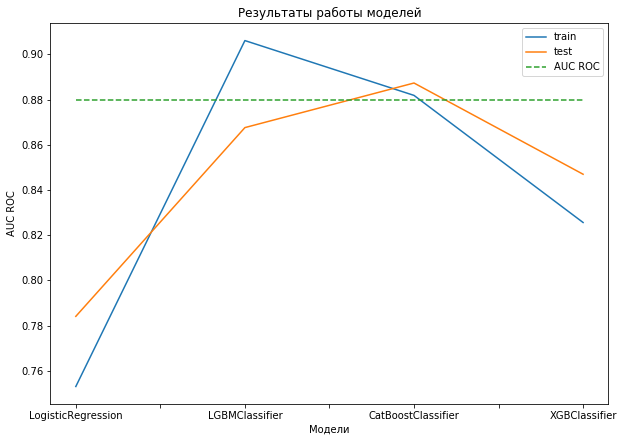

In [62]:
_, ax = plt.subplots(1, figsize=(10,7))
result.train.plot(ax=ax)
result.test.plot(ax=ax)
plt.plot(np.array([0.88 for i in range(len(result))]), '--')
legend = list(result.columns) + ['AUC ROC']
ax.legend(legend)
ax.set_ylabel('AUC ROC')
ax.set_xlabel('Модели')
ax.set_title('Результаты работы моделей');

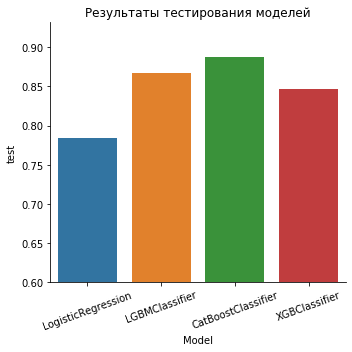

In [63]:
df = result.reset_index()
df.columns = ["Model", "train", "test"]
sns.catplot(data=df, kind="bar", x="Model", y="test")
plt.ylim(0.6)
plt.title("Результаты тестирования моделей")
plt.xticks(rotation=20);
plt.tight_layout()
plt.savefig('tmp.png')

При решении задачи использовались 4 алгоритма:
* LogisticRegression - при оптимизации параметров удалось добиться значения метрики AUC ROC, равным лишь ~0.78 на тестовой выборке
* LightGBM - демонстрируется более высокие результаты - ~0.867
* CatBoost - показал наилучшие результаты - ~0.887
* XGBClassifier - результаты, сравнимые с LightGBM - ~0.85

Медленнее всего обучается LightGBM, быстрее LogisticRegression и XGBClassifier. Модель CatBoost достаточно быстно учится (~25 c), демонстрируя наиболее точный результат.

# Вывод

При выполнении задачи выполнены все пункты плана.

**1. Выполнен исследовательский анализ данных**

Выяснено, что основной отток приходится на пользователей интернета, причем перечень дополнительных услуг практически не влияет на факт ухода клиента. *18% оттока* пользуется оптоволоконным интернетом. 
Также, клиенты, которые уходят, переплачивают примерно в 2 раза по сравнению с оставшимися. Резкое увеличение количества ушедших клиентов в 2018-2019 году.

**2. Кодирование признаков *Type, PaymentMethod, InternetService* ***

Также выполнено кодирование признака *gender*. Также был добавлен новый признак - длительность контракты (в днях).

**3. Исследование на важность признаков**

С помощью алгоритма RandomizedSearchCV() выло выполнено исследование важности ризнаков в совокупности с корреляционным анализом. В результате для будущей модели были исключены такие признаки, как *пол, некоторые услуги ('StreamingTV', 'StreamingMovies', 'DeviceProtection', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'TechSupport'), оплаты ('TotalCharges', 'MonthlyCharges'), тип оплаты 'PaymentMethod_Mailed check' и наличие детей 'Dependents'.* В ходе экспериментов было выяснено, что выбранные признаки не влияют на качество моделей или местами его улучшают.

**4. Исследование на необходимость балансировки классов**

В ходе работы экспериментально было выяснено, что балансировка классов существенно улучшает качество модели. Поэтому было принято решение применить технику *upsampling*.

**5. Построение модели для задачи бинарной классификации**

Выполнено построение четырех моделей на основе алгоритмов LogisticRegression, CatBoost, LighGBM, XGBoost с применением интрументов перекрестной проверки. Для оценки качества использовались метрики *Accuracy, AUC-ROC*. Также для дополнительных оценок качества разрабатываемых моделей использовались метрики *Recall, Precision, F1*. Итоговое решение о качестве модели принималось по метрике AUC-ROC.

В результате анализа результатов была выбрана модель на основе CatBoost. Достоинства модели:
* достаточно быстрое обучение (~25 секунд)
* работа с требуемым качеством (AUC-ROC 0.887).